In [1]:
import pandas as pd

# Load the CSV file into a DataFrame
file_path = './cwes_by_problem.csv'
try:
    df = pd.read_csv(file_path)
except Exception as e:
    print(f'An error occurred while reading the file: {e}')

# Show the first few rows of the DataFrame
df.head()

,problem,cwe,tool,frequency
0,158,686,gcc,2
1,973,126,flawfinder,1
2,900,686,gcc,1
3,674,457,cppcheck,1
4,972,690,gcc,3


In [4]:
from sklearn.preprocessing import OneHotEncoder
import numpy as np

encoder = OneHotEncoder(sparse=False)
encoded_data = encoder.fit_transform(df[['cwe', 'tool']])
encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(['cwe', 'tool']))
weighted_encoded_df = encoded_df.multiply(df['frequency'], axis=0)

# Add the 'problem' column back to the DataFrame
weighted_encoded_df['problem'] = df['problem']

# Group the data by 'problem' and sum the encoded columns
grouped_df = weighted_encoded_df.groupby('problem').sum().reset_index()

grouped_df.head()

/usr/local/Caskroom/miniconda/base/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,problem,cwe_20,cwe_119,cwe_120,cwe_124,cwe_126,cwe_127,cwe_129,cwe_190,cwe_369,...,cwe_628,cwe_686,cwe_690,cwe_704,cwe_843,cwe_908,cwe_1260,tool_cppcheck,tool_flawfinder,tool_gcc
0,5,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4.0
1,9,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0
2,11,1.0,1.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0
3,18,2.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0
4,30,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


/usr/local/Caskroom/miniconda/base/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


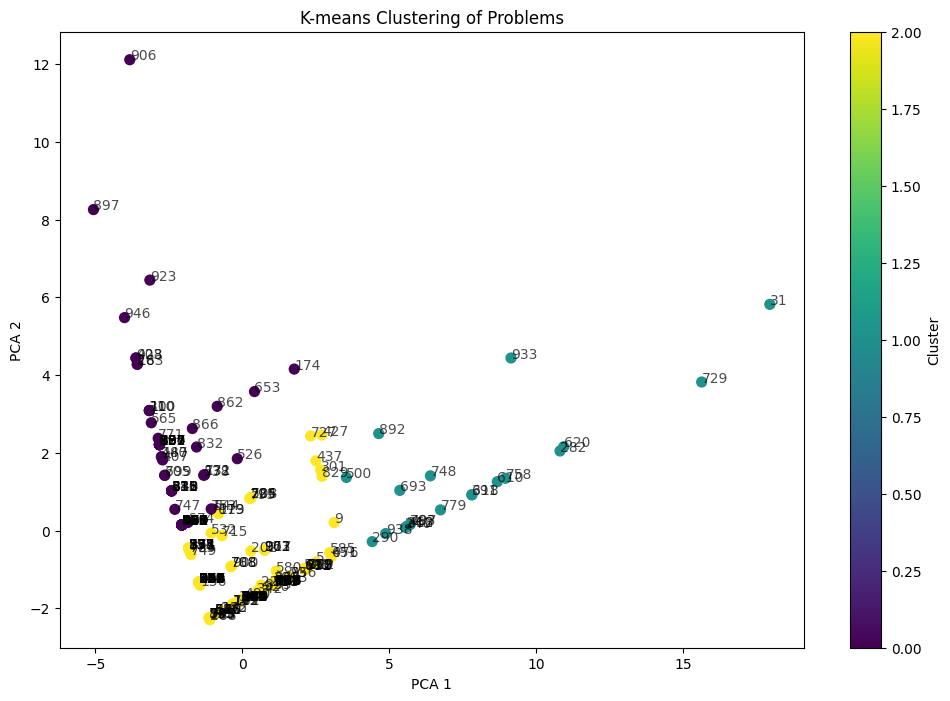

In [64]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Initialize K-means clustering model
kmeans = KMeans(n_clusters=3, random_state=42)
X = grouped_df.drop(columns=['problem'])
kmeans_labels = kmeans.fit_predict(X)

grouped_df['cluster'] = kmeans_labels
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X)
plt.figure(figsize=(12, 8))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=kmeans_labels, cmap='viridis', s=50)
for i, problem in enumerate(grouped_df['problem']):
    plt.annotate(problem, (X_reduced[i, 0], X_reduced[i, 1]), fontsize=10, alpha=0.7)


# visualize the clusters
plt.title('K-means Clustering of Problems')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.colorbar().set_label('Cluster')
plt.show()

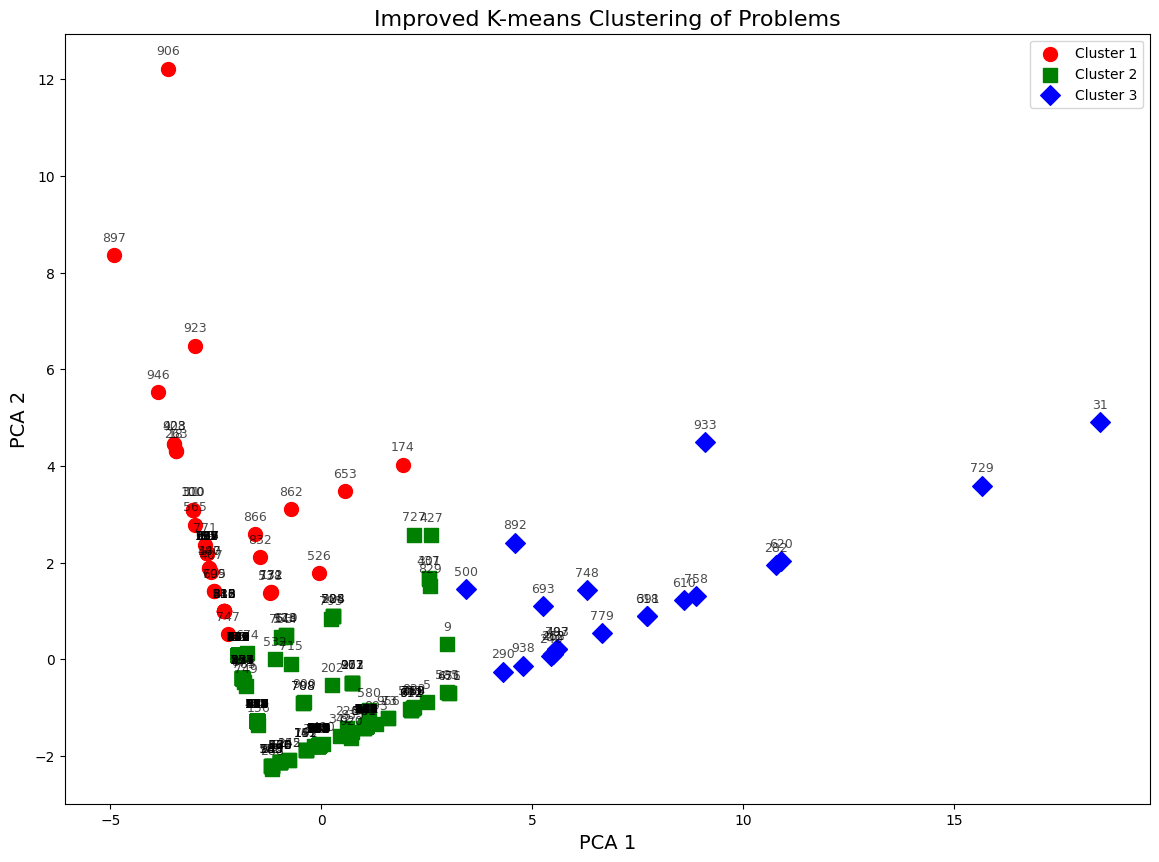

In [21]:

markers = ['o', 's', 'D']

colors = ['r', 'g', 'b']

# Red, Green, Blue
plt.figure(figsize=(14, 10))

# Plot each cluster with a unique marker and color
for cluster in np.unique(kmeans_labels):
    plt.scatter(X_reduced[kmeans_labels == cluster, 0], X_reduced[kmeans_labels == cluster, 1], s=100, c=colors[cluster], label=f'Cluster {cluster+1}', marker=markers[cluster])

# Annotate the points with problem numbers
for i, problem in enumerate(grouped_df['problem']):
    plt.annotate(problem, (X_reduced[i, 0], X_reduced[i, 1]), textcoords='offset points', xytext=(0, 10), ha='center', fontsize=9, alpha=0.7)

# visualize the clusters
plt.title('Improved K-means Clustering of Problems', fontsize=16)
plt.xlabel('PCA 1', fontsize=14)
plt.ylabel('PCA 2', fontsize=14)

# legend
plt.legend(loc='upper right')

# Show plot
plt.show()

In [48]:
problems_by_cluster = []
for cluster in np.unique(kmeans_labels):
    for i, problem in enumerate(grouped_df['problem']):
        cluster_elements_x = X_reduced[kmeans_labels == cluster, 0]
        cluster_elements_y = X_reduced[kmeans_labels == cluster, 1]
        if (X_reduced[i, 0] in cluster_elements_x and 
           X_reduced[i, 1] in cluster_elements_y):
           problems_by_cluster.append(
               {
                    "problem": problem,
                    "cluster": cluster,
               }
            )
problems_by_cluster_df = pd.DataFrame(problems_by_cluster)
problems_by_cluster_df.to_csv('problems_by_cluster.csv')
problems_by_cluster_df.head()

,problem,cluster
0,11,0
1,18,0
2,39,0
3,83,0
4,100,0


In [49]:
count_of_problems_by_cluster = problems_by_cluster_df.groupby('cluster').count()
count_of_problems_by_cluster.head()

,problem
cluster,
0,48
1,166
2,21


/usr/local/Caskroom/miniconda/base/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/Caskroom/miniconda/base/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/Caskroom/miniconda/base/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/Caskroom/miniconda/base/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a futu

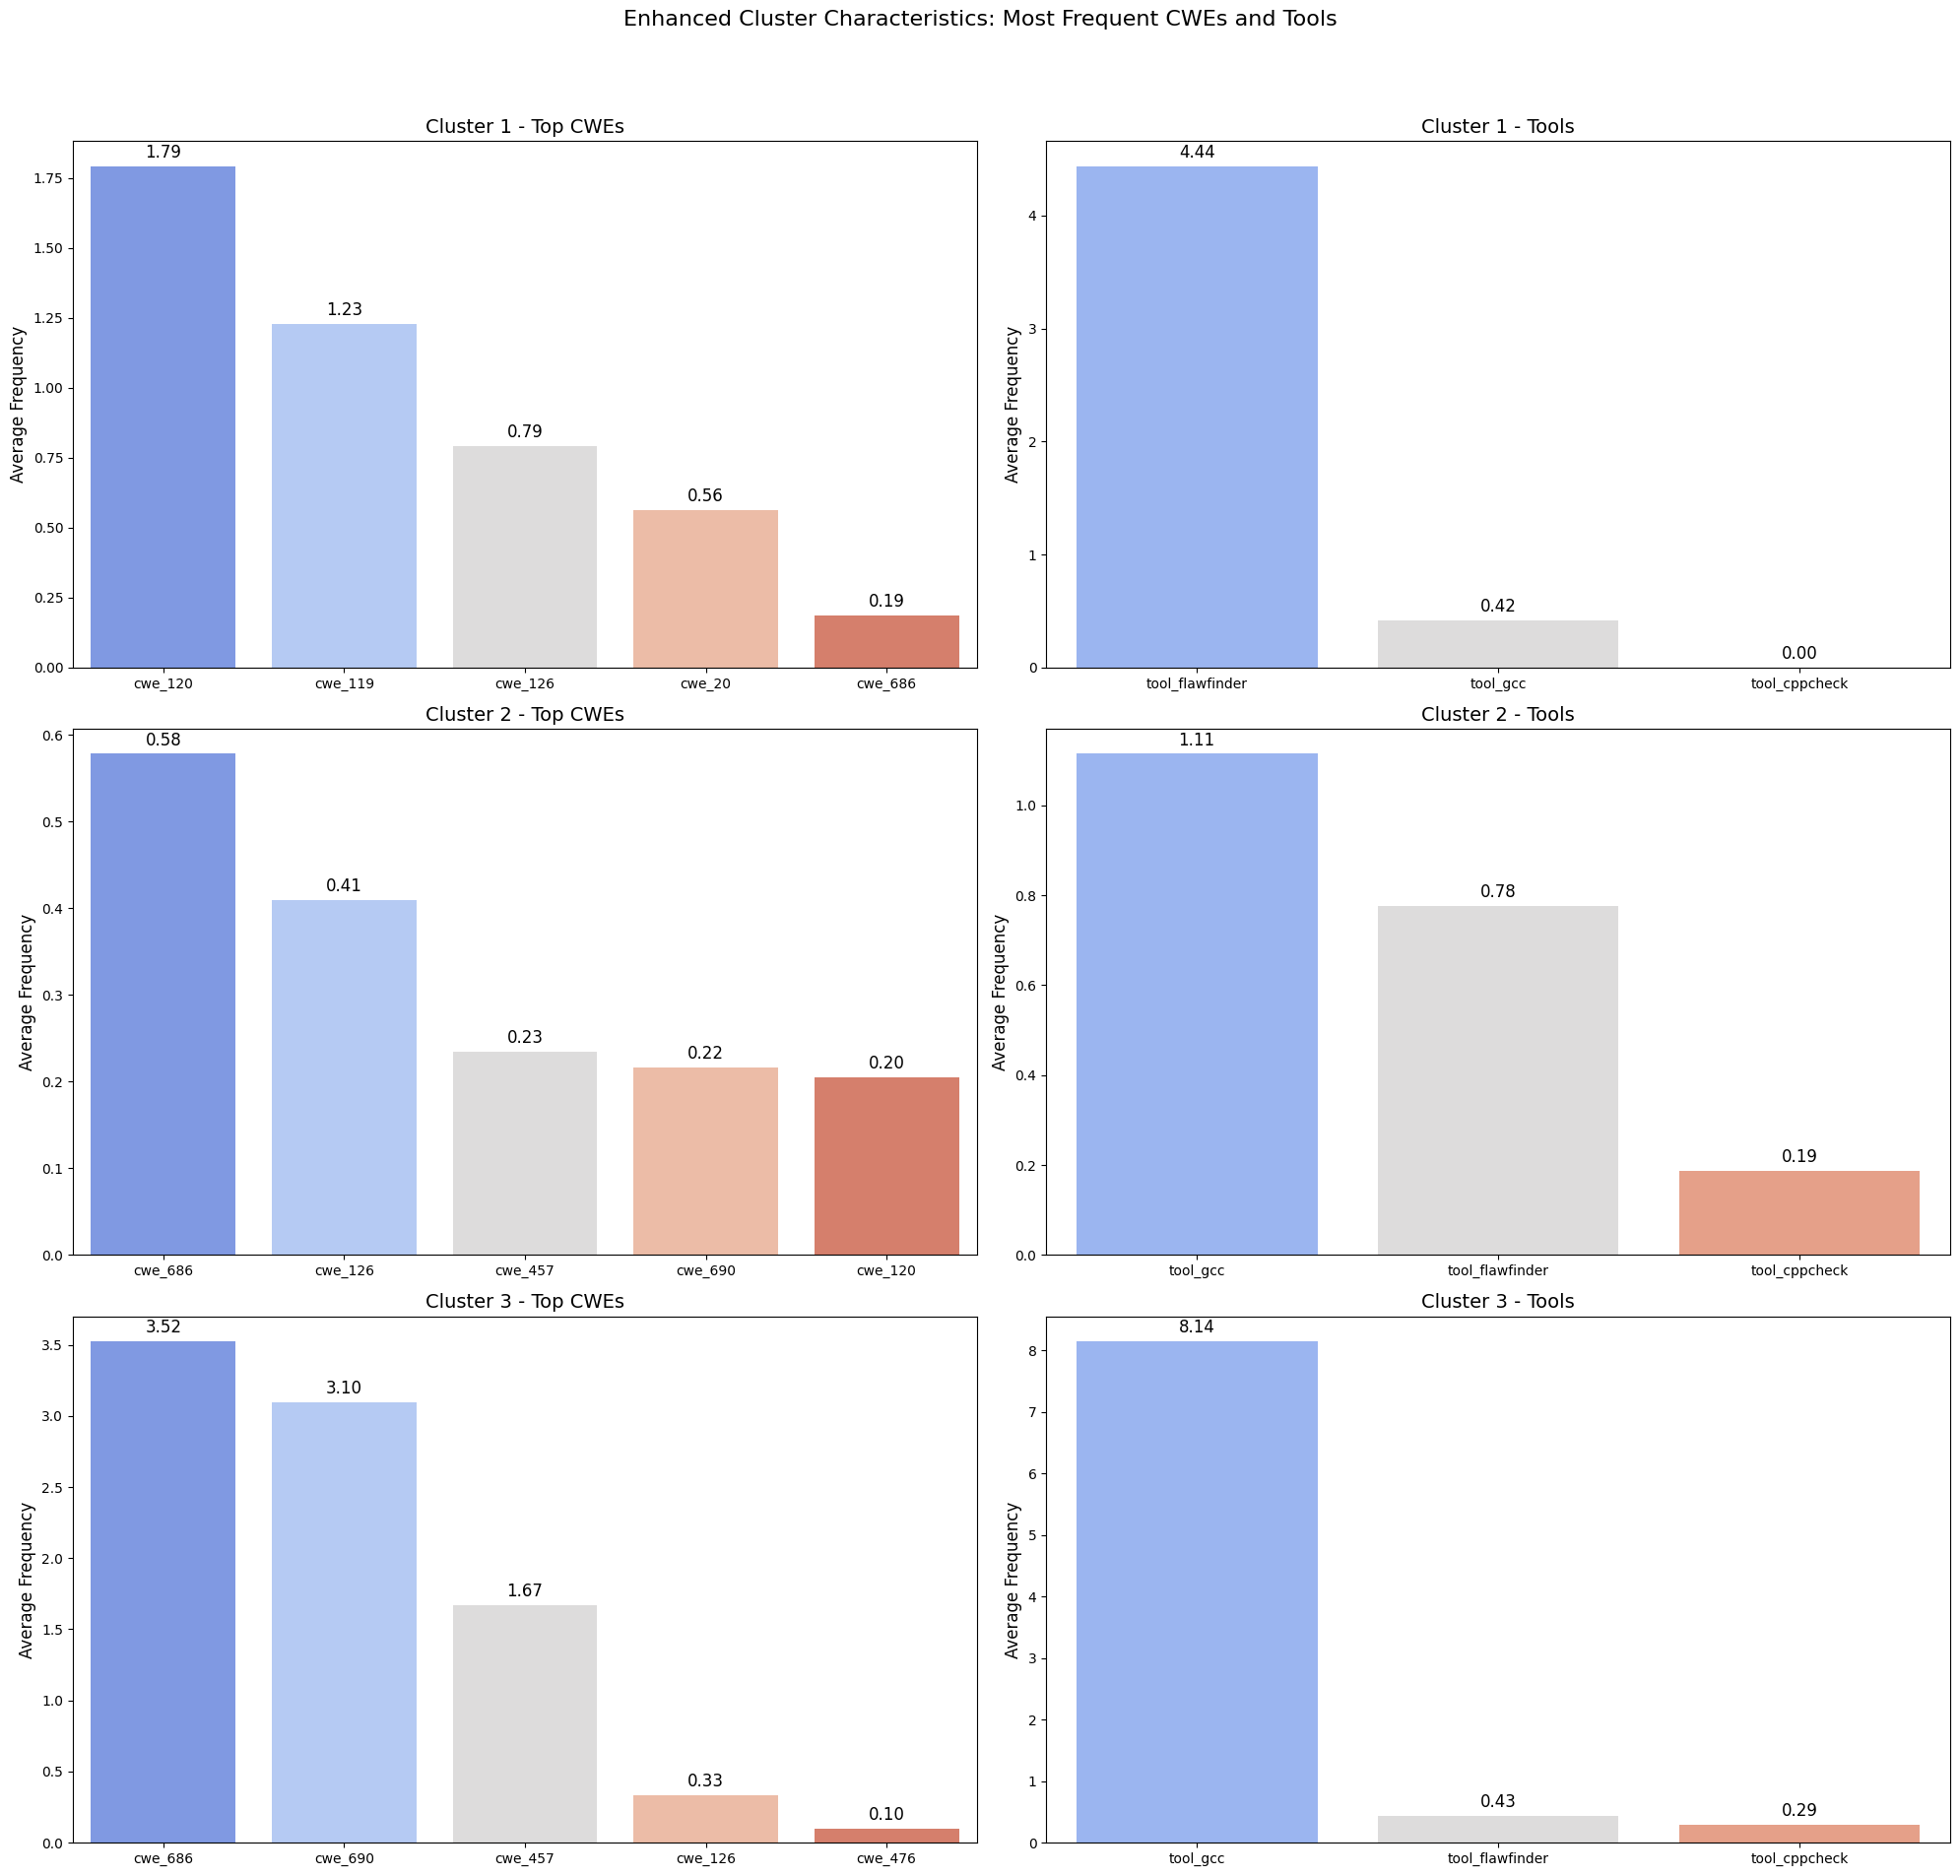

In [51]:
import seaborn as sns

# Initialize a figure for subplots
fig, axes = plt.subplots(3, 2, figsize=(20, 20))

def annotate_bars(ax):
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.2f}', 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='center', 
                    xytext=(0, 10), textcoords='offset points', 
                    fontsize=12)


for cluster in np.unique(kmeans_labels):
    cluster_data = grouped_df[grouped_df['cluster'] == cluster]
    
    # Calculate the mean of CWEs and Tools for the cluster
    cwe_means = cluster_data.loc[:, 'cwe_20':'cwe_1260'].mean().sort_values(ascending=False)[:5]
    tool_means = cluster_data.loc[:, 'tool_cppcheck':'tool_gcc'].mean().sort_values(ascending=False)
    
    # Plot CWEs
    ax1 = sns.barplot(x=cwe_means.index, y=cwe_means.values, ax=axes[cluster, 0], palette='coolwarm')
    axes[cluster, 0].set_title(f'Cluster {cluster+1} - Top CWEs', fontsize=14)
    axes[cluster, 0].set_ylabel('Average Frequency', fontsize=12)
    annotate_bars(ax1)
    
    # Plot Tools
    ax2 = sns.barplot(x=tool_means.index, y=tool_means.values, ax=axes[cluster, 1], palette='coolwarm')
    axes[cluster, 1].set_title(f'Cluster {cluster+1} - Tools', fontsize=14)
    axes[cluster, 1].set_ylabel('Average Frequency', fontsize=12)
    annotate_bars(ax2)

# Add titles and labels
fig.suptitle('Enhanced Cluster Characteristics: Most Frequent CWEs and Tools', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
